In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, backtest, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters

CPU times: user 5.57 s, sys: 4.31 s, total: 9.87 s
Wall time: 2.03 s


In [2]:
# papermill parameters
SEED_LIST = [
             0,
             #1111,
             #2222, 
             #3333, 
             #4444, 
             #5555,
             #6666,
             #7777,
             #8888,
             #9999
            ]

#TICKERS = market_tickers.DOW_30_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2019-01-01' # start of backtest
UNTIL = '2020-01-01' # end of backtest
NB_EPISODES = 200 # backtest model that was trained for this number of episodes

# investor preferences
GAMMA_TRADES = [0.1, 1, 10, 100]
GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
GAMMA_HOLDS = [0.1, 1]

In [3]:
# Parameters
SEED_LIST = [0]
TICKERS = [
    "AAPL",
    "MSFT",
    "JPM",
    "V",
    "RTX",
    "PG",
    "GS",
    "NKE",
    "DIS",
    "AXP",
    "HD",
    "INTC",
    "WMT",
    "IBM",
    "MRK",
    "UNH",
    "KO",
    "CAT",
    "TRV",
    "JNJ",
    "CVX",
    "MCD",
    "VZ",
    "CSCO",
    "XOM",
    "BA",
    "MMM",
    "PFE",
    "WBA",
    "DD",
]
MARKET_NAME = "DOW_30"
MODEL_BASE_NAME = "RL_CNN"
FROM = "2018-01-01"
UNTIL = "2020-01-01"
NB_EPISODES = 200
GAMMA_TRADES = [1, 7, 8, 9, 10, 11, 12, 50, 100]
GAMMA_RISKS = [1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000, 5000, 10000]
GAMMA_HOLDS = [0.1, 1, 10, 100, 1000, 10000]


In [4]:
#------ small test-sweep ------#
# GAMMA_TRADES = [0.1, 1, 10, 100]
# GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
# GAMMA_HOLDS = [0.1, 1]
#------ extended-boyd-sweep ------#
# GAMMA_TRADES =  [0.1, 0.5, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 11, 12, 15, 20, 30, 45, 60, 100, 200]
# GAMMA_RISKS = [0.1, 0.178, 0.316, 0.562, 1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000, 2000, 5000, 10000, 20000]
#---------------------------------#

GAMMA_TRIOS = []
for tr in GAMMA_TRADES:
    for ri in GAMMA_RISKS:
        for hd in GAMMA_HOLDS:
            GAMMA_TRIOS.append((tr, ri, hd))
        
#format: (gamma_trade, gamma_risk, gamma_hold)
print('number of trios: ', len(GAMMA_TRIOS))
#GAMMA_TRIOS

number of trios:  810


In [5]:
# other constants and parameters
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value

USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

TEST_NAME = f'{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc'
RESULTS_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/backtests/'
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

## create agent(s) and backtest in new backtest env

In [6]:
%%time
# make directory for results if it does not exist already
maybe_make_dir(RESULTS_DIR)

print('creating environment and agent...')
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    #gamma_risk=GAMMA_RISK, 
                    #gamma_trade=GAMMA_TRADE,
                    #half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    #distribution=EPISODE_DRAW_DISTRIBUTION,
                    #days_duration=DAYS_IN_EPISODE, 
                    mode='backtest', 
                    random_seed=7,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE,
              allow_long_short_trades=True)

results_dict = {}
#actions_dict = {}
print('backtesting:')

total_backtests = len(SEED_LIST) * len(GAMMA_TRIOS)
backtest_counter = 0

for RANDOM_SEED in SEED_LIST:
    for (GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD) in GAMMA_TRIOS:
        
        backtest_counter += 1
        print(f'\t[{backtest_counter}/{total_backtests}]\t{MODEL_BASE_NAME}: gamma_trade={GAMMA_TRADE}, gamma_risk={GAMMA_RISK}, gamma_hold={GAMMA_HOLD}, seed={RANDOM_SEED}...')
        
        # load trained RL model for backtesting
        SAVED_MODEL_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}/models/{MODEL_BASE_NAME}_seed_{RANDOM_SEED}_{NB_EPISODES}'
        # set dir where actions csv file will be saved
        actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}'
        
        try:
            rl_rets, rl_actions = backtest(agent, env, weights_file_dir=SAVED_MODEL_DIR, verbose=False)
            
            #rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[1:].index)
            #rl_actions = pd.DataFrame(data=rl_actions, index=env.returns.loc[FROM:UNTIL].iloc[0:].index, columns=TICKERS+['USDOLLAR'])
            rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[:-1].index)
            rl_rets = rl_rets.shift(1)
            rl_rets.iloc[0] = 0
            rl_actions = pd.DataFrame(data=rl_actions[:-1], index=env.returns.loc[FROM:UNTIL].iloc[:-1].index, columns=TICKERS+['USDOLLAR'])
            
            # save actions
            rl_actions.to_csv(f'{actions_dir}/actions.csv')
            #print('actions saved.')

            cash_rets = env.returns.loc[FROM:UNTIL, env.cash_key].iloc[:-1]
            excess_rets = rl_rets - cash_rets

            R_e = excess_rets.mean() * 100 * 252
            sigma_e = excess_rets.std() * 100 * np.sqrt(252)
            sharpe = R_e / sigma_e

            results_dict[(GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD, RANDOM_SEED)] = {'excess_return':R_e, 'excess_risk':sigma_e, 'sharpe':sharpe}
        except Exception as e:
            print(f'**error for model: trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}')
            #print(e)

creating environment and agent...


backtesting:
	[1/810]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=0.1, seed=0...


	[2/810]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=1, seed=0...


	[3/810]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=10, seed=0...


	[4/810]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=100, seed=0...


	[5/810]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=1000, seed=0...


	[6/810]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=10000, seed=0...


	[7/810]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=0.1, seed=0...


	[8/810]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=1, seed=0...
**error for model: trade_1_risk_2_hold_1
	[9/810]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=10, seed=0...


	[10/810]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=100, seed=0...


	[11/810]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=1000, seed=0...


	[12/810]	RL_CNN: gamma_trade=1, gamma_risk=2, gamma_hold=10000, seed=0...


	[13/810]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=0.1, seed=0...


	[14/810]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=1, seed=0...


	[15/810]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=10, seed=0...


	[16/810]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=100, seed=0...


	[17/810]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=1000, seed=0...


	[18/810]	RL_CNN: gamma_trade=1, gamma_risk=3, gamma_hold=10000, seed=0...


	[19/810]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=0.1, seed=0...


	[20/810]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=1, seed=0...


	[21/810]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=10, seed=0...


	[22/810]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=100, seed=0...


	[23/810]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=1000, seed=0...


	[24/810]	RL_CNN: gamma_trade=1, gamma_risk=6, gamma_hold=10000, seed=0...


	[25/810]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=0.1, seed=0...


	[26/810]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=1, seed=0...


	[27/810]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=10, seed=0...


	[28/810]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=100, seed=0...


	[29/810]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=1000, seed=0...


	[30/810]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=10000, seed=0...


	[31/810]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=0.1, seed=0...


	[32/810]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=1, seed=0...


	[33/810]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=10, seed=0...


	[34/810]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=100, seed=0...


	[35/810]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=1000, seed=0...


	[36/810]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=10000, seed=0...


	[37/810]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=0.1, seed=0...


	[38/810]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=1, seed=0...


	[39/810]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=10, seed=0...


	[40/810]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=100, seed=0...


	[41/810]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=1000, seed=0...


	[42/810]	RL_CNN: gamma_trade=1, gamma_risk=32, gamma_hold=10000, seed=0...


	[43/810]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=0.1, seed=0...


	[44/810]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=1, seed=0...


	[45/810]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=10, seed=0...


	[46/810]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=100, seed=0...


	[47/810]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=1000, seed=0...


	[48/810]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=10000, seed=0...


	[49/810]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=0.1, seed=0...


	[50/810]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=1, seed=0...


	[51/810]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=10, seed=0...


	[52/810]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=100, seed=0...


	[53/810]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=1000, seed=0...


	[54/810]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=10000, seed=0...


	[55/810]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=0.1, seed=0...


	[56/810]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=1, seed=0...


	[57/810]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=10, seed=0...


	[58/810]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=100, seed=0...


	[59/810]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=1000, seed=0...


	[60/810]	RL_CNN: gamma_trade=1, gamma_risk=178, gamma_hold=10000, seed=0...


	[61/810]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=0.1, seed=0...


	[62/810]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=1, seed=0...


	[63/810]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=10, seed=0...


	[64/810]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=100, seed=0...


	[65/810]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=1000, seed=0...


	[66/810]	RL_CNN: gamma_trade=1, gamma_risk=316, gamma_hold=10000, seed=0...


	[67/810]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=0.1, seed=0...


	[68/810]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=1, seed=0...


	[69/810]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=10, seed=0...


	[70/810]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=100, seed=0...


	[71/810]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=1000, seed=0...


	[72/810]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=10000, seed=0...


	[73/810]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[74/810]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=1, seed=0...


	[75/810]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=10, seed=0...


	[76/810]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=100, seed=0...


	[77/810]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=1000, seed=0...


	[78/810]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=10000, seed=0...


	[79/810]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[80/810]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=1, seed=0...


	[81/810]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=10, seed=0...


	[82/810]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=100, seed=0...


	[83/810]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=1000, seed=0...


	[84/810]	RL_CNN: gamma_trade=1, gamma_risk=5000, gamma_hold=10000, seed=0...


	[85/810]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[86/810]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=1, seed=0...


	[87/810]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=10, seed=0...


	[88/810]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=100, seed=0...


	[89/810]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=1000, seed=0...


	[90/810]	RL_CNN: gamma_trade=1, gamma_risk=10000, gamma_hold=10000, seed=0...


	[91/810]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=0.1, seed=0...


	[92/810]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1, seed=0...


	[93/810]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=10, seed=0...


	[94/810]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=100, seed=0...


	[95/810]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1000, seed=0...


	[96/810]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=10000, seed=0...


	[97/810]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=0.1, seed=0...


	[98/810]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1, seed=0...


	[99/810]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=10, seed=0...


	[100/810]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=100, seed=0...


	[101/810]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1000, seed=0...


	[102/810]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=10000, seed=0...


	[103/810]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=0.1, seed=0...


	[104/810]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1, seed=0...


	[105/810]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=10, seed=0...


	[106/810]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=100, seed=0...


	[107/810]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1000, seed=0...


	[108/810]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=10000, seed=0...


	[109/810]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=0.1, seed=0...


	[110/810]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1, seed=0...


	[111/810]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=10, seed=0...


	[112/810]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=100, seed=0...


	[113/810]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1000, seed=0...


	[114/810]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=10000, seed=0...


	[115/810]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=0.1, seed=0...


	[116/810]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1, seed=0...


	[117/810]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=10, seed=0...


	[118/810]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=100, seed=0...


	[119/810]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1000, seed=0...


	[120/810]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=10000, seed=0...


	[121/810]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=0.1, seed=0...


	[122/810]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1, seed=0...


	[123/810]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=10, seed=0...


	[124/810]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=100, seed=0...


	[125/810]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1000, seed=0...


	[126/810]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=10000, seed=0...


	[127/810]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=0.1, seed=0...


	[128/810]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1, seed=0...


	[129/810]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=10, seed=0...


	[130/810]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=100, seed=0...


	[131/810]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1000, seed=0...


	[132/810]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=10000, seed=0...


	[133/810]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=0.1, seed=0...


	[134/810]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1, seed=0...


	[135/810]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=10, seed=0...


	[136/810]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=100, seed=0...


	[137/810]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1000, seed=0...


	[138/810]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=10000, seed=0...


	[139/810]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=0.1, seed=0...


	[140/810]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1, seed=0...


	[141/810]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=10, seed=0...


	[142/810]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=100, seed=0...


	[143/810]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1000, seed=0...


	[144/810]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=10000, seed=0...


	[145/810]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=0.1, seed=0...


	[146/810]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1, seed=0...


	[147/810]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=10, seed=0...


	[148/810]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=100, seed=0...


	[149/810]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1000, seed=0...


	[150/810]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=10000, seed=0...


	[151/810]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=0.1, seed=0...


	[152/810]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1, seed=0...


	[153/810]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=10, seed=0...


	[154/810]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=100, seed=0...


	[155/810]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1000, seed=0...


	[156/810]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=10000, seed=0...


	[157/810]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=0.1, seed=0...


	[158/810]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1, seed=0...


	[159/810]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=10, seed=0...


	[160/810]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=100, seed=0...


	[161/810]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1000, seed=0...


	[162/810]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=10000, seed=0...


	[163/810]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[164/810]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1, seed=0...


	[165/810]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=10, seed=0...


	[166/810]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=100, seed=0...


	[167/810]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1000, seed=0...


	[168/810]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=10000, seed=0...


	[169/810]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[170/810]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=1, seed=0...


	[171/810]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=10, seed=0...


	[172/810]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=100, seed=0...


	[173/810]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=1000, seed=0...


	[174/810]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=10000, seed=0...


	[175/810]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[176/810]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=1, seed=0...


	[177/810]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=10, seed=0...


	[178/810]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=100, seed=0...


	[179/810]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=1000, seed=0...


	[180/810]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=10000, seed=0...


	[181/810]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=0.1, seed=0...


	[182/810]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1, seed=0...


	[183/810]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=10, seed=0...


	[184/810]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=100, seed=0...


	[185/810]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1000, seed=0...


	[186/810]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=10000, seed=0...


	[187/810]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=0.1, seed=0...


	[188/810]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1, seed=0...


	[189/810]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=10, seed=0...


	[190/810]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=100, seed=0...


	[191/810]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1000, seed=0...


	[192/810]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=10000, seed=0...


	[193/810]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=0.1, seed=0...


	[194/810]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1, seed=0...


	[195/810]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=10, seed=0...


	[196/810]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=100, seed=0...


	[197/810]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1000, seed=0...


	[198/810]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=10000, seed=0...


	[199/810]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=0.1, seed=0...


	[200/810]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1, seed=0...


	[201/810]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=10, seed=0...


	[202/810]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=100, seed=0...


	[203/810]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1000, seed=0...


	[204/810]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=10000, seed=0...


	[205/810]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=0.1, seed=0...


	[206/810]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1, seed=0...


	[207/810]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=10, seed=0...


	[208/810]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=100, seed=0...


	[209/810]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1000, seed=0...


	[210/810]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=10000, seed=0...


	[211/810]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=0.1, seed=0...


	[212/810]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1, seed=0...


	[213/810]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=10, seed=0...


	[214/810]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=100, seed=0...


	[215/810]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1000, seed=0...


	[216/810]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=10000, seed=0...


	[217/810]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=0.1, seed=0...


	[218/810]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1, seed=0...


	[219/810]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=10, seed=0...


	[220/810]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=100, seed=0...


	[221/810]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1000, seed=0...


	[222/810]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=10000, seed=0...


	[223/810]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=0.1, seed=0...


	[224/810]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1, seed=0...


	[225/810]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=10, seed=0...


	[226/810]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=100, seed=0...


	[227/810]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1000, seed=0...


	[228/810]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=10000, seed=0...


	[229/810]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=0.1, seed=0...


	[230/810]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1, seed=0...


	[231/810]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=10, seed=0...


	[232/810]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=100, seed=0...


	[233/810]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1000, seed=0...


	[234/810]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=10000, seed=0...


	[235/810]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=0.1, seed=0...


	[236/810]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1, seed=0...


	[237/810]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=10, seed=0...


	[238/810]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=100, seed=0...


	[239/810]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1000, seed=0...


	[240/810]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=10000, seed=0...


	[241/810]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=0.1, seed=0...


	[242/810]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1, seed=0...


	[243/810]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=10, seed=0...


	[244/810]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=100, seed=0...


	[245/810]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1000, seed=0...


	[246/810]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=10000, seed=0...


	[247/810]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=0.1, seed=0...


	[248/810]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1, seed=0...


	[249/810]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=10, seed=0...


	[250/810]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=100, seed=0...


	[251/810]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1000, seed=0...


	[252/810]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=10000, seed=0...


	[253/810]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[254/810]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1, seed=0...


	[255/810]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=10, seed=0...


	[256/810]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=100, seed=0...


	[257/810]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1000, seed=0...


	[258/810]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=10000, seed=0...


	[259/810]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[260/810]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=1, seed=0...


	[261/810]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=10, seed=0...


	[262/810]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=100, seed=0...


	[263/810]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=1000, seed=0...


	[264/810]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=10000, seed=0...


	[265/810]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[266/810]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=1, seed=0...


	[267/810]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=10, seed=0...


	[268/810]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=100, seed=0...


	[269/810]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=1000, seed=0...


	[270/810]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=10000, seed=0...


	[271/810]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=0.1, seed=0...


	[272/810]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1, seed=0...


	[273/810]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=10, seed=0...


	[274/810]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=100, seed=0...


	[275/810]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1000, seed=0...


	[276/810]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=10000, seed=0...


	[277/810]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=0.1, seed=0...


	[278/810]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1, seed=0...


	[279/810]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=10, seed=0...


	[280/810]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=100, seed=0...


	[281/810]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1000, seed=0...


	[282/810]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=10000, seed=0...


	[283/810]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=0.1, seed=0...


	[284/810]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1, seed=0...


	[285/810]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=10, seed=0...


	[286/810]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=100, seed=0...


	[287/810]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1000, seed=0...


	[288/810]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=10000, seed=0...


	[289/810]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=0.1, seed=0...


	[290/810]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1, seed=0...


	[291/810]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=10, seed=0...


	[292/810]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=100, seed=0...


	[293/810]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1000, seed=0...


	[294/810]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=10000, seed=0...


	[295/810]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=0.1, seed=0...


	[296/810]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1, seed=0...


	[297/810]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=10, seed=0...


	[298/810]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=100, seed=0...


	[299/810]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1000, seed=0...


	[300/810]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=10000, seed=0...


	[301/810]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=0.1, seed=0...


	[302/810]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1, seed=0...


	[303/810]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=10, seed=0...


	[304/810]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=100, seed=0...


	[305/810]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1000, seed=0...


	[306/810]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=10000, seed=0...


	[307/810]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=0.1, seed=0...


	[308/810]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1, seed=0...


	[309/810]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=10, seed=0...


	[310/810]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=100, seed=0...


	[311/810]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1000, seed=0...


	[312/810]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=10000, seed=0...


	[313/810]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=0.1, seed=0...


	[314/810]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1, seed=0...


	[315/810]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=10, seed=0...


	[316/810]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=100, seed=0...


	[317/810]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1000, seed=0...


	[318/810]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=10000, seed=0...


	[319/810]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=0.1, seed=0...


	[320/810]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1, seed=0...


	[321/810]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=10, seed=0...


	[322/810]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=100, seed=0...


	[323/810]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1000, seed=0...


	[324/810]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=10000, seed=0...


	[325/810]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=0.1, seed=0...


	[326/810]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1, seed=0...


	[327/810]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=10, seed=0...


	[328/810]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=100, seed=0...


	[329/810]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1000, seed=0...


	[330/810]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=10000, seed=0...


	[331/810]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=0.1, seed=0...


	[332/810]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1, seed=0...


	[333/810]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=10, seed=0...


	[334/810]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=100, seed=0...


	[335/810]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1000, seed=0...


	[336/810]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=10000, seed=0...


	[337/810]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=0.1, seed=0...


	[338/810]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1, seed=0...


	[339/810]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=10, seed=0...


	[340/810]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=100, seed=0...


	[341/810]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1000, seed=0...


	[342/810]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=10000, seed=0...


	[343/810]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[344/810]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1, seed=0...


	[345/810]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=10, seed=0...


	[346/810]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=100, seed=0...


	[347/810]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1000, seed=0...


	[348/810]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=10000, seed=0...


	[349/810]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[350/810]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=1, seed=0...


	[351/810]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=10, seed=0...


	[352/810]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=100, seed=0...


	[353/810]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=1000, seed=0...


	[354/810]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=10000, seed=0...


	[355/810]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[356/810]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=1, seed=0...


	[357/810]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=10, seed=0...


	[358/810]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=100, seed=0...


	[359/810]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=1000, seed=0...


	[360/810]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=10000, seed=0...


	[361/810]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=0.1, seed=0...


	[362/810]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1, seed=0...


	[363/810]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=10, seed=0...


	[364/810]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=100, seed=0...


	[365/810]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1000, seed=0...


	[366/810]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=10000, seed=0...


	[367/810]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=0.1, seed=0...


	[368/810]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1, seed=0...


	[369/810]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=10, seed=0...


	[370/810]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=100, seed=0...


	[371/810]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1000, seed=0...


	[372/810]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=10000, seed=0...


	[373/810]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=0.1, seed=0...


	[374/810]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1, seed=0...


	[375/810]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=10, seed=0...


	[376/810]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=100, seed=0...


	[377/810]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1000, seed=0...


	[378/810]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=10000, seed=0...


	[379/810]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=0.1, seed=0...


	[380/810]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1, seed=0...


	[381/810]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=10, seed=0...


	[382/810]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=100, seed=0...


	[383/810]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1000, seed=0...


	[384/810]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=10000, seed=0...


	[385/810]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=0.1, seed=0...


	[386/810]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1, seed=0...


	[387/810]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=10, seed=0...


	[388/810]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=100, seed=0...


	[389/810]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1000, seed=0...


	[390/810]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=10000, seed=0...


	[391/810]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=0.1, seed=0...


	[392/810]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1, seed=0...


	[393/810]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=10, seed=0...


	[394/810]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=100, seed=0...


	[395/810]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1000, seed=0...


	[396/810]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=10000, seed=0...


	[397/810]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=0.1, seed=0...


	[398/810]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1, seed=0...


	[399/810]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=10, seed=0...


	[400/810]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=100, seed=0...


	[401/810]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1000, seed=0...


	[402/810]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=10000, seed=0...


	[403/810]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=0.1, seed=0...


	[404/810]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1, seed=0...


	[405/810]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=10, seed=0...


	[406/810]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=100, seed=0...


	[407/810]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1000, seed=0...


	[408/810]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=10000, seed=0...


	[409/810]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=0.1, seed=0...


	[410/810]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1, seed=0...


	[411/810]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=10, seed=0...


	[412/810]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=100, seed=0...


	[413/810]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1000, seed=0...


	[414/810]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=10000, seed=0...


	[415/810]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=0.1, seed=0...


	[416/810]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1, seed=0...


	[417/810]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=10, seed=0...


	[418/810]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=100, seed=0...


	[419/810]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1000, seed=0...


	[420/810]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=10000, seed=0...


	[421/810]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=0.1, seed=0...


	[422/810]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1, seed=0...


	[423/810]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=10, seed=0...


	[424/810]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=100, seed=0...


	[425/810]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1000, seed=0...


	[426/810]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=10000, seed=0...


	[427/810]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=0.1, seed=0...


	[428/810]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1, seed=0...


	[429/810]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=10, seed=0...


	[430/810]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=100, seed=0...


	[431/810]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1000, seed=0...


	[432/810]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=10000, seed=0...


	[433/810]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[434/810]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1, seed=0...


	[435/810]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=10, seed=0...


	[436/810]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=100, seed=0...


	[437/810]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1000, seed=0...


	[438/810]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=10000, seed=0...


	[439/810]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[440/810]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=1, seed=0...


	[441/810]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=10, seed=0...


	[442/810]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=100, seed=0...


	[443/810]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=1000, seed=0...


	[444/810]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=10000, seed=0...


	[445/810]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[446/810]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=1, seed=0...


	[447/810]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=10, seed=0...


	[448/810]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=100, seed=0...


	[449/810]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=1000, seed=0...


	[450/810]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=10000, seed=0...


	[451/810]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=0.1, seed=0...


	[452/810]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1, seed=0...


	[453/810]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=10, seed=0...


	[454/810]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=100, seed=0...


	[455/810]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1000, seed=0...


	[456/810]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=10000, seed=0...


	[457/810]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=0.1, seed=0...


	[458/810]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1, seed=0...


	[459/810]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=10, seed=0...


	[460/810]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=100, seed=0...


	[461/810]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1000, seed=0...


	[462/810]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=10000, seed=0...


	[463/810]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=0.1, seed=0...


	[464/810]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1, seed=0...


	[465/810]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=10, seed=0...


	[466/810]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=100, seed=0...


	[467/810]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1000, seed=0...


	[468/810]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=10000, seed=0...


	[469/810]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=0.1, seed=0...


	[470/810]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1, seed=0...


	[471/810]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=10, seed=0...


	[472/810]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=100, seed=0...


	[473/810]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1000, seed=0...


	[474/810]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=10000, seed=0...


	[475/810]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=0.1, seed=0...


	[476/810]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1, seed=0...


	[477/810]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=10, seed=0...


	[478/810]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=100, seed=0...


	[479/810]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1000, seed=0...


	[480/810]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=10000, seed=0...


	[481/810]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=0.1, seed=0...


	[482/810]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1, seed=0...


	[483/810]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=10, seed=0...


	[484/810]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=100, seed=0...


	[485/810]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1000, seed=0...


	[486/810]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=10000, seed=0...


	[487/810]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=0.1, seed=0...


	[488/810]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1, seed=0...


	[489/810]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=10, seed=0...


	[490/810]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=100, seed=0...


	[491/810]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1000, seed=0...


	[492/810]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=10000, seed=0...


	[493/810]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=0.1, seed=0...


	[494/810]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1, seed=0...


	[495/810]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=10, seed=0...


	[496/810]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=100, seed=0...


	[497/810]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1000, seed=0...


	[498/810]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=10000, seed=0...


	[499/810]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=0.1, seed=0...


	[500/810]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1, seed=0...


	[501/810]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=10, seed=0...


	[502/810]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=100, seed=0...


	[503/810]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1000, seed=0...


	[504/810]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=10000, seed=0...


	[505/810]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=0.1, seed=0...


	[506/810]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1, seed=0...


	[507/810]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=10, seed=0...


	[508/810]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=100, seed=0...


	[509/810]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1000, seed=0...


	[510/810]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=10000, seed=0...


	[511/810]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=0.1, seed=0...


	[512/810]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1, seed=0...


	[513/810]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=10, seed=0...


	[514/810]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=100, seed=0...


	[515/810]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1000, seed=0...


	[516/810]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=10000, seed=0...


	[517/810]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=0.1, seed=0...


	[518/810]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1, seed=0...


	[519/810]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=10, seed=0...


	[520/810]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=100, seed=0...


	[521/810]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1000, seed=0...


	[522/810]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=10000, seed=0...


	[523/810]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[524/810]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1, seed=0...


	[525/810]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=10, seed=0...


	[526/810]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=100, seed=0...


	[527/810]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1000, seed=0...


	[528/810]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=10000, seed=0...


	[529/810]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[530/810]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=1, seed=0...


	[531/810]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=10, seed=0...


	[532/810]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=100, seed=0...


	[533/810]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=1000, seed=0...


	[534/810]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=10000, seed=0...


	[535/810]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[536/810]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=1, seed=0...


	[537/810]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=10, seed=0...


	[538/810]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=100, seed=0...


	[539/810]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=1000, seed=0...


	[540/810]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=10000, seed=0...


	[541/810]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=0.1, seed=0...


	[542/810]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1, seed=0...


	[543/810]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=10, seed=0...


	[544/810]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=100, seed=0...


	[545/810]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1000, seed=0...


	[546/810]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=10000, seed=0...


	[547/810]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=0.1, seed=0...


	[548/810]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1, seed=0...


	[549/810]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=10, seed=0...


	[550/810]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=100, seed=0...


	[551/810]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1000, seed=0...


	[552/810]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=10000, seed=0...


	[553/810]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=0.1, seed=0...


	[554/810]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1, seed=0...


	[555/810]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=10, seed=0...


	[556/810]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=100, seed=0...


	[557/810]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1000, seed=0...


	[558/810]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=10000, seed=0...


	[559/810]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=0.1, seed=0...


	[560/810]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1, seed=0...


	[561/810]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=10, seed=0...


	[562/810]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=100, seed=0...


	[563/810]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1000, seed=0...


	[564/810]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=10000, seed=0...


	[565/810]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=0.1, seed=0...


	[566/810]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1, seed=0...


	[567/810]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=10, seed=0...


	[568/810]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=100, seed=0...


	[569/810]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1000, seed=0...


	[570/810]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=10000, seed=0...


	[571/810]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=0.1, seed=0...


	[572/810]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1, seed=0...


	[573/810]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=10, seed=0...


	[574/810]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=100, seed=0...


	[575/810]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1000, seed=0...


	[576/810]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=10000, seed=0...


	[577/810]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=0.1, seed=0...


	[578/810]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1, seed=0...


	[579/810]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=10, seed=0...


	[580/810]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=100, seed=0...


	[581/810]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1000, seed=0...


	[582/810]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=10000, seed=0...


	[583/810]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=0.1, seed=0...


	[584/810]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1, seed=0...


	[585/810]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=10, seed=0...


	[586/810]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=100, seed=0...


	[587/810]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1000, seed=0...


	[588/810]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=10000, seed=0...


	[589/810]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=0.1, seed=0...


	[590/810]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1, seed=0...


	[591/810]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=10, seed=0...


	[592/810]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=100, seed=0...


	[593/810]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1000, seed=0...


	[594/810]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=10000, seed=0...


	[595/810]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=0.1, seed=0...


	[596/810]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1, seed=0...


	[597/810]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=10, seed=0...


	[598/810]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=100, seed=0...


	[599/810]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1000, seed=0...


	[600/810]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=10000, seed=0...


	[601/810]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=0.1, seed=0...


	[602/810]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1, seed=0...


	[603/810]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=10, seed=0...


	[604/810]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=100, seed=0...


	[605/810]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1000, seed=0...


	[606/810]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=10000, seed=0...


	[607/810]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=0.1, seed=0...


	[608/810]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1, seed=0...


	[609/810]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=10, seed=0...


	[610/810]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=100, seed=0...


	[611/810]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1000, seed=0...


	[612/810]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=10000, seed=0...


	[613/810]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[614/810]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1, seed=0...


	[615/810]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=10, seed=0...


	[616/810]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=100, seed=0...


	[617/810]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1000, seed=0...


	[618/810]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=10000, seed=0...


	[619/810]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[620/810]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=1, seed=0...


	[621/810]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=10, seed=0...


	[622/810]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=100, seed=0...


	[623/810]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=1000, seed=0...


	[624/810]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=10000, seed=0...


	[625/810]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[626/810]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=1, seed=0...


	[627/810]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=10, seed=0...


	[628/810]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=100, seed=0...


	[629/810]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=1000, seed=0...


	[630/810]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=10000, seed=0...


	[631/810]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=0.1, seed=0...


	[632/810]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=1, seed=0...


	[633/810]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=10, seed=0...


	[634/810]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=100, seed=0...


	[635/810]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=1000, seed=0...


	[636/810]	RL_CNN: gamma_trade=50, gamma_risk=1, gamma_hold=10000, seed=0...


	[637/810]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=0.1, seed=0...


	[638/810]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=1, seed=0...


	[639/810]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=10, seed=0...


	[640/810]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=100, seed=0...


	[641/810]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=1000, seed=0...


	[642/810]	RL_CNN: gamma_trade=50, gamma_risk=2, gamma_hold=10000, seed=0...


	[643/810]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=0.1, seed=0...


	[644/810]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=1, seed=0...


	[645/810]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=10, seed=0...


	[646/810]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=100, seed=0...


	[647/810]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=1000, seed=0...


	[648/810]	RL_CNN: gamma_trade=50, gamma_risk=3, gamma_hold=10000, seed=0...


	[649/810]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=0.1, seed=0...


	[650/810]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=1, seed=0...


	[651/810]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=10, seed=0...


	[652/810]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=100, seed=0...


	[653/810]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=1000, seed=0...


	[654/810]	RL_CNN: gamma_trade=50, gamma_risk=6, gamma_hold=10000, seed=0...


	[655/810]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=0.1, seed=0...


	[656/810]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=1, seed=0...


	[657/810]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=10, seed=0...


	[658/810]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=100, seed=0...


	[659/810]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=1000, seed=0...


	[660/810]	RL_CNN: gamma_trade=50, gamma_risk=10, gamma_hold=10000, seed=0...


	[661/810]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=0.1, seed=0...


	[662/810]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=1, seed=0...


	[663/810]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=10, seed=0...


	[664/810]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=100, seed=0...


	[665/810]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=1000, seed=0...


	[666/810]	RL_CNN: gamma_trade=50, gamma_risk=18, gamma_hold=10000, seed=0...


	[667/810]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=0.1, seed=0...


	[668/810]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=1, seed=0...


	[669/810]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=10, seed=0...


	[670/810]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=100, seed=0...


	[671/810]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=1000, seed=0...


	[672/810]	RL_CNN: gamma_trade=50, gamma_risk=32, gamma_hold=10000, seed=0...


	[673/810]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=0.1, seed=0...


	[674/810]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=1, seed=0...


	[675/810]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=10, seed=0...


	[676/810]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=100, seed=0...


	[677/810]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=1000, seed=0...


	[678/810]	RL_CNN: gamma_trade=50, gamma_risk=56, gamma_hold=10000, seed=0...


	[679/810]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=0.1, seed=0...


	[680/810]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=1, seed=0...


	[681/810]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=10, seed=0...


	[682/810]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=100, seed=0...


	[683/810]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=1000, seed=0...


	[684/810]	RL_CNN: gamma_trade=50, gamma_risk=100, gamma_hold=10000, seed=0...


	[685/810]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=0.1, seed=0...


	[686/810]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=1, seed=0...


	[687/810]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=10, seed=0...


	[688/810]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=100, seed=0...


	[689/810]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=1000, seed=0...


	[690/810]	RL_CNN: gamma_trade=50, gamma_risk=178, gamma_hold=10000, seed=0...


	[691/810]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=0.1, seed=0...


	[692/810]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=1, seed=0...


	[693/810]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=10, seed=0...


	[694/810]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=100, seed=0...


	[695/810]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=1000, seed=0...


	[696/810]	RL_CNN: gamma_trade=50, gamma_risk=316, gamma_hold=10000, seed=0...


	[697/810]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=0.1, seed=0...


	[698/810]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=1, seed=0...


	[699/810]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=10, seed=0...


	[700/810]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=100, seed=0...


	[701/810]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=1000, seed=0...


	[702/810]	RL_CNN: gamma_trade=50, gamma_risk=562, gamma_hold=10000, seed=0...


	[703/810]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[704/810]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=1, seed=0...


	[705/810]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=10, seed=0...


	[706/810]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=100, seed=0...


	[707/810]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=1000, seed=0...


	[708/810]	RL_CNN: gamma_trade=50, gamma_risk=1000, gamma_hold=10000, seed=0...


	[709/810]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[710/810]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=1, seed=0...


	[711/810]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=10, seed=0...


	[712/810]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=100, seed=0...


	[713/810]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=1000, seed=0...


	[714/810]	RL_CNN: gamma_trade=50, gamma_risk=5000, gamma_hold=10000, seed=0...


	[715/810]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[716/810]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=1, seed=0...


	[717/810]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=10, seed=0...


	[718/810]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=100, seed=0...


	[719/810]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=1000, seed=0...


	[720/810]	RL_CNN: gamma_trade=50, gamma_risk=10000, gamma_hold=10000, seed=0...


	[721/810]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=0.1, seed=0...


	[722/810]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=1, seed=0...


	[723/810]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=10, seed=0...


	[724/810]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=100, seed=0...


	[725/810]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=1000, seed=0...


	[726/810]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=10000, seed=0...


	[727/810]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=0.1, seed=0...


	[728/810]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=1, seed=0...


	[729/810]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=10, seed=0...


	[730/810]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=100, seed=0...


	[731/810]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=1000, seed=0...


	[732/810]	RL_CNN: gamma_trade=100, gamma_risk=2, gamma_hold=10000, seed=0...


	[733/810]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=0.1, seed=0...


	[734/810]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=1, seed=0...


	[735/810]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=10, seed=0...


	[736/810]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=100, seed=0...


	[737/810]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=1000, seed=0...


	[738/810]	RL_CNN: gamma_trade=100, gamma_risk=3, gamma_hold=10000, seed=0...


	[739/810]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=0.1, seed=0...


	[740/810]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=1, seed=0...


	[741/810]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=10, seed=0...


	[742/810]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=100, seed=0...


	[743/810]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=1000, seed=0...


	[744/810]	RL_CNN: gamma_trade=100, gamma_risk=6, gamma_hold=10000, seed=0...


	[745/810]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=0.1, seed=0...


	[746/810]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=1, seed=0...


	[747/810]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=10, seed=0...


	[748/810]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=100, seed=0...


	[749/810]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=1000, seed=0...


	[750/810]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=10000, seed=0...


	[751/810]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=0.1, seed=0...


	[752/810]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=1, seed=0...


	[753/810]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=10, seed=0...


	[754/810]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=100, seed=0...


	[755/810]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=1000, seed=0...


	[756/810]	RL_CNN: gamma_trade=100, gamma_risk=18, gamma_hold=10000, seed=0...


	[757/810]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=0.1, seed=0...


	[758/810]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=1, seed=0...


	[759/810]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=10, seed=0...


	[760/810]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=100, seed=0...


	[761/810]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=1000, seed=0...


	[762/810]	RL_CNN: gamma_trade=100, gamma_risk=32, gamma_hold=10000, seed=0...


	[763/810]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=0.1, seed=0...


	[764/810]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=1, seed=0...


	[765/810]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=10, seed=0...


	[766/810]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=100, seed=0...


	[767/810]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=1000, seed=0...


	[768/810]	RL_CNN: gamma_trade=100, gamma_risk=56, gamma_hold=10000, seed=0...


	[769/810]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=0.1, seed=0...


	[770/810]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=1, seed=0...


	[771/810]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=10, seed=0...


	[772/810]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=100, seed=0...


	[773/810]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=1000, seed=0...


	[774/810]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=10000, seed=0...


	[775/810]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=0.1, seed=0...


	[776/810]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=1, seed=0...


	[777/810]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=10, seed=0...


	[778/810]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=100, seed=0...


	[779/810]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=1000, seed=0...


	[780/810]	RL_CNN: gamma_trade=100, gamma_risk=178, gamma_hold=10000, seed=0...


	[781/810]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=0.1, seed=0...


	[782/810]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=1, seed=0...


	[783/810]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=10, seed=0...


	[784/810]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=100, seed=0...


	[785/810]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=1000, seed=0...


	[786/810]	RL_CNN: gamma_trade=100, gamma_risk=316, gamma_hold=10000, seed=0...


	[787/810]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=0.1, seed=0...


	[788/810]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=1, seed=0...


	[789/810]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=10, seed=0...


	[790/810]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=100, seed=0...


	[791/810]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=1000, seed=0...


	[792/810]	RL_CNN: gamma_trade=100, gamma_risk=562, gamma_hold=10000, seed=0...


	[793/810]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[794/810]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=1, seed=0...


	[795/810]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=10, seed=0...


	[796/810]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=100, seed=0...


	[797/810]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=1000, seed=0...


	[798/810]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=10000, seed=0...


	[799/810]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[800/810]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=1, seed=0...


	[801/810]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=10, seed=0...


	[802/810]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=100, seed=0...


	[803/810]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=1000, seed=0...


	[804/810]	RL_CNN: gamma_trade=100, gamma_risk=5000, gamma_hold=10000, seed=0...


	[805/810]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[806/810]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=1, seed=0...


	[807/810]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=10, seed=0...


	[808/810]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=100, seed=0...


	[809/810]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=1000, seed=0...


	[810/810]	RL_CNN: gamma_trade=100, gamma_risk=10000, gamma_hold=10000, seed=0...


CPU times: user 2h 35min 55s, sys: 5.9 s, total: 2h 36min 1s
Wall time: 2h 35min 57s


In [7]:
results_df = pd.DataFrame(results_dict).T.reset_index()
results_df.columns = ['gamma_trade', 'gamma_risk', 'gamma_hold', 'seed', 'excess_return', 'excess_risk', 'sharpe']
results_df.to_csv(RESULTS_DIR+TEST_NAME+'.csv', index=False)
print('saved.')
results_df

saved.


,gamma_trade,gamma_risk,gamma_hold,seed,excess_return,excess_risk,sharpe
0,1,1,0.1,0,-3.338371,13.405354,-0.249033
1,1,1,1.0,0,10.443099,17.552840,0.594952
2,1,1,10.0,0,10.323385,16.350307,0.631388
3,1,1,100.0,0,10.952082,15.584963,0.702734
4,1,1,1000.0,0,10.043109,14.999377,0.669568
...,...,...,...,...,...,...,...
804,100,10000,1.0,0,3.654706,11.631226,0.314215
805,100,10000,10.0,0,3.559158,11.583937,0.307249
806,100,10000,100.0,0,3.639015,11.629340,0.312917
807,100,10000,1000.0,0,6.628873,11.964050,0.554066


(-10.0, 70.0)

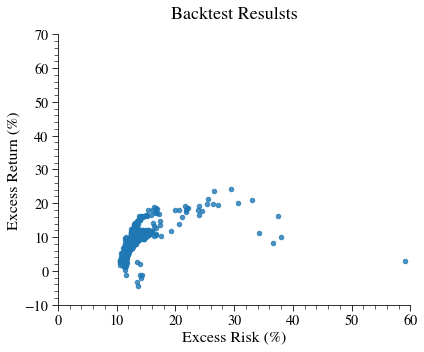

In [8]:
# risk-return plot 
results_df[['excess_return', 'excess_risk']]\
    .rename(
        columns={
            'excess_return':'Excess Return (%)', 
            'excess_risk':'Excess Risk (%)'
        })\
    .plot(
        kind='scatter', 
        x='Excess Risk (%)', 
        y='Excess Return (%)', 
        title='Backtest Resulsts', 
        alpha=0.8,
        figsize=(6,5),
        c='C0')

# x and y axis limits
plt.xlim(left=0.0, right=60.0)
plt.ylim(bottom=-10.0, top=70.0)

In [9]:
print(f'done backtesting for {MODEL_BASE_NAME}.')

done backtesting for RL_CNN.


In [10]:
agent.policy